In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import kornia
import torch

In [2]:
intrinsic_matrices = np.load('intrinsic_matrices.npy',)
extrinsic_matrices = np.load('extrinsic_matrices.npy',)
worldgrid2worldcoord_mat = np.load('worldgrid2worldcoord_mat.npy',)

cam = 0
K = intrinsic_matrices[cam]
K[:2,:3] /= 4
inv_K = np.linalg.inv(K)
inv_K_g = worldgrid2worldcoord_mat
inv_K_g[:2,:2] *= 4
K_g = np.linalg.inv(inv_K_g)
h0 = np.asarray(
    [[ 1.77127424e-04,  9.68763313e-04, -9.67998026e-02],
    [ 1.03478445e-04,  1.99934532e-04,  6.48696438e-02],
    [-2.00390772e-07,  7.75412512e-06, -2.55026117e-06]])
inv_h0 = np.linalg.inv(h0)
# head
hv, hu = 307/4, 780/4
# foot
fv, fu = 759/4, 780/4
# bev
x, y = 116*inv_K_g[0,0]+inv_K_g[0,2], 85*inv_K_g[1,1]+inv_K_g[1,2]

e0 = inv_K @ inv_h0 @ K_g
ed = e0.copy()
ed_gt = e0.copy()

devide = e0[2,0]*x+e0[2,1]*y+e0[2,2]
delta_t = np.asarray([
    ((hu-fu)*inv_K[0,0])*devide,
    ((hv-fv)*inv_K[1,1])*devide,
    0])
print(delta_t)
delta_t_gt = extrinsic_matrices[cam][:,2] * 142
ed[:,2] += delta_t
ed_gt[:,2] += delta_t_gt
hd = K_g @ np.linalg.inv(ed) @ inv_K
hd_gt = K_g @ np.linalg.inv(ed_gt) @ inv_K

[   0.         -142.79386415    0.        ]


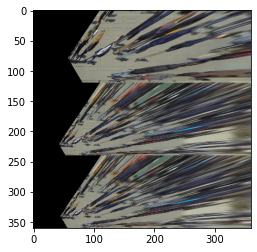

In [3]:
input_img = torch.tensor(np.asarray(Image.open('image-f0.png')).copy().transpose(2,0,1))[None].float()

out = kornia.warp_perspective(input_img, torch.tensor(h0)[None].float(), [360,120])
i1 = out[0].numpy().transpose(2,1,0)/255

out = kornia.warp_perspective(input_img, torch.tensor(hd)[None].float(), [360,120])
i2 = out[0].numpy().transpose(2,1,0)/255

out = kornia.warp_perspective(input_img, torch.tensor(hd_gt)[None].float(), [360,120])
i3 = out[0].numpy().transpose(2,1,0)/255

img = np.zeros([i1.shape[0]*3,i1.shape[1],3])
h = i1.shape[0]
img[:h,:,:] = i1
img[h:2*h,:,:] = i2
img[2*h:,:,:] = i3
img = (img*255).astype('uint8')
plt.imshow(img)
plt.imsave('i1.png', i1)
plt.imsave('i2.png', i2)
plt.imsave('i3.png', i3)
# t = Image.fromarray(img)
# t.save('compare.png')

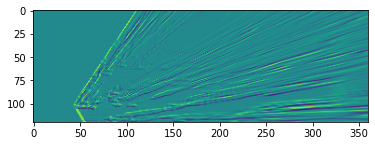

In [4]:
plt.imshow((i2/255-i3/255)[:,:,0])
# plt.imsave('diff.png', (i2/255-i3/255)[:,:,0])